In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score 
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
TEST_SIZE = 0.2
RANDOM_STATE =42
PATH = 'C:/ITC/final project/fake news/bias/Baseline/balanced_data_extremes.csv/'
FILE_NAME = 'balanced_data_extremes.csv'
CHUNKSIZE = 50000
VEC_SIZE=256
CLASSES = {-1: 'Left', 0: 'Center', 1: 'Right'}
N_CLASSES = 3

In [4]:
models_metrics = []

# Seperate content and title:
## CountVectorize

In [5]:
# Pre-processing for seperate content and title:
content_vectorizer = CountVectorizer(max_features=VEC_SIZE,
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

title_vectorizer = CountVectorizer(max_features=VEC_SIZE,
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

content_vec = []
title_vec = []
labels = []

with pd.read_csv(PATH + FILE_NAME, chunksize=CHUNKSIZE, 
                 usecols=['title', 'content', 'bias'], iterator=True) as reader:
    
    # Fitting the vectors on the first chunk:
    first_chunk = reader.get_chunk()
    first_chunk['content'].fillna('', inplace=True)
    first_chunk['title'].fillna('', inplace=True)

    content_vectorizer.fit(first_chunk['content']) 
    title_vectorizer.fit(first_chunk['title'])
    
    # Tranforming all data to vectors:
    for df_sub in tqdm(reader):
        print(df_sub.shape)
        df_sub['content'].fillna('', inplace=True)
        df_sub['title'].fillna('', inplace=True)
        content_vec.append(content_vectorizer.transform(df_sub['content']).toarray())
        title_vec.append(title_vectorizer.transform(df_sub['title']).toarray())
        labels.append(df_sub['bias'])      

0it [00:00, ?it/s]

(50000, 3)


1it [00:16, 16.80s/it]

(50000, 3)


2it [00:36, 18.31s/it]

(15414, 3)


3it [00:42, 14.14s/it]


In [6]:
content_vec = np.concatenate(np.array(content_vec))
title_vec = np.concatenate(np.array(title_vec))
labels = np.concatenate(np.array(labels))

In [7]:
content_vec.shape, title_vec.shape, labels.shape

((115414, 256), (115414, 256), (115414,))

## Splitting:

In [8]:
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(content_vec, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(title_vec, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

In [9]:
X_train_cont.shape, X_test_cont.shape, y_train_cont.shape, y_test_cont.shape

X_train_title.shape, X_test_title.shape, y_train_title.shape, y_test_title.shape

((92331, 256), (23083, 256), (92331,), (23083,))

## Modeling:
### Content
#### Naive Bayes:

In [10]:
clf = MultinomialNB()
clf.fit(X=X_train_cont, y=y_train_cont)
clf.score(X_test_cont, y_test_cont)

0.6162110644197029

In [12]:
model = 'count_content'
model_dict = {'model': model,
              'clf': clf,
                 'accuracy': clf.score(X_test_cont, y_test_cont),
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test_cont)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

### Title
#### Naive Bayes:

In [14]:
clf = MultinomialNB()
clf.fit(X_train_title, y_train_title)
title_nb_score = clf.score(X_test_title, y_test_title) # accuracy score

title_nb_score

0.5630117402417364

In [15]:
model = 'count_title'
model_dict = {'model': model,
                 'accuracy': clf.score(X_test_title, y_test_title),
              'clf': clf,
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test_title)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

# United content and title:
## CountVectorize

In [16]:
# Pre-processing for seperate content and title:

vectorizer = CountVectorizer(max_features=VEC_SIZE,
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

vectors = []
labels = []

with pd.read_csv(PATH + FILE_NAME, chunksize=CHUNKSIZE, 
                 usecols=['title', 'content', 'bias'], iterator=True) as reader:
    
    # Fitting the vectors on the first chunk:
    first_chunk = reader.get_chunk()
    first_chunk['content'].fillna('', inplace=True)
    first_chunk['title'].fillna('', inplace=True)

    vectorizer.fit(first_chunk['content'] + first_chunk['title']) 
    
    # Tranforming all data to vectors:
    for df_sub in tqdm(reader):
        print(df_sub.shape)
        df_sub['content'].fillna('', inplace=True)
        df_sub['title'].fillna('', inplace=True)
        vectors.append(content_vectorizer.transform(df_sub['content'] + df_sub['title']).toarray())
        labels.append(df_sub['bias'])      

0it [00:00, ?it/s]

(50000, 3)


1it [00:18, 18.20s/it]

(50000, 3)


2it [00:37, 18.84s/it]

(15414, 3)


3it [00:44, 14.92s/it]


In [17]:
vectors = np.concatenate(np.array(vectors))
labels = np.concatenate(np.array(labels))

In [18]:
vectors.shape, labels.shape

((115414, 256), (115414,))

### Splitting:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92331, 256), (23083, 256), (92331,), (23083,))

### Modeling:
#### Naive Bayes:

In [20]:
clf = MultinomialNB()
clf.fit(X=X_train, y=y_train)
nb_score = clf.score(X_test, y_test) # accuracy score

nb_score

0.6159944547935711

In [21]:
model = 'count_both'
model_dict = {'model': model,
              'clf': clf,
                 'accuracy': clf.score(X_test, y_test),
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

# TF-IDF

In [81]:
# Pre-processing for seperate content and title:
content_vectorizer = TfidfVectorizer(max_features=VEC_SIZE,
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

title_vectorizer = TfidfVectorizer(max_features=VEC_SIZE,
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

content_vec = []
title_vec = []
labels = []

with pd.read_csv(PATH + FILE_NAME, chunksize=CHUNKSIZE, 
                 usecols=['title', 'content', 'bias'], iterator=True) as reader:
    
    # Fitting the vectors on the first chunk:
    first_chunk = reader.get_chunk()
    first_chunk['content'].fillna('', inplace=True)
    first_chunk['title'].fillna('', inplace=True)

    content_vectorizer.fit(first_chunk['content']) 
    title_vectorizer.fit(first_chunk['title'])
    
    # Tranforming all data to vectors:
    for df_sub in tqdm(reader):
        print(df_sub.shape)
        df_sub['content'].fillna('', inplace=True)
        df_sub['title'].fillna('', inplace=True)
        content_vec.append(content_vectorizer.transform(df_sub['content']).toarray())
        title_vec.append(title_vectorizer.transform(df_sub['title']).toarray())
        labels.append(df_sub['bias'])      

0it [00:00, ?it/s]

(50000, 3)


1it [00:15, 15.76s/it]

(50000, 3)


2it [00:31, 16.04s/it]

(15414, 3)


3it [00:37, 12.53s/it]


In [82]:
content_vec = np.concatenate(np.array(content_vec))
title_vec = np.concatenate(np.array(title_vec))
labels = np.concatenate(np.array(labels))

In [83]:
content_vec.shape, title_vec.shape, labels.shape

((115414, 256), (115414, 256), (115414,))

## Splitting:

In [84]:
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(content_vec, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(title_vec, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

In [85]:
X_train_cont.shape, X_test_cont.shape, y_train_cont.shape, y_test_cont.shape

X_train_title.shape, X_test_title.shape, y_train_title.shape, y_test_title.shape

((92331, 256), (23083, 256), (92331,), (23083,))

In [86]:
X_train_best, X_test_best, y_train_best, y_test_best = X_train_cont.copy(), X_test_cont.copy(), y_train_cont.copy(), y_test_cont.copy()

In [105]:
best_vectorizer = content_vectorizer

## Modeling:
### Content
#### Naive Bayes:

In [87]:
clf = MultinomialNB()
clf.fit(X=X_train_cont, y=y_train_cont)
cont_nb_score = clf.score(X_test_cont, y_test_cont) # accuracy score

cont_nb_score

0.6610925789542087

In [88]:
model = 'tfidf_content'
model_dict = {'model': model,
              'clf': clf,
                 'accuracy': clf.score(X_test_cont, y_test_cont),
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test_cont)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

### Title
#### Naive Bayes:

In [29]:
clf = MultinomialNB()
clf.fit(X_train_title, y_train_title)
title_nb_score = clf.score(X_test_title, y_test_title) # accuracy score

title_nb_score

0.5622752675128883

In [30]:
model = 'tfidf_title'
model_dict = {'model': model,
              'clf': clf,
                 'accuracy': clf.score(X_test_title, y_test_title),
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test_title)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

# United content and title:
## TF-IDF

In [31]:
# Pre-processing for seperate content and title:

vectorizer = TfidfVectorizer(max_features=VEC_SIZE,
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

vectors = []
labels = []

with pd.read_csv(PATH + FILE_NAME, chunksize=CHUNKSIZE, 
                 usecols=['title', 'content', 'bias'], iterator=True) as reader:
    
    # Fitting the vectors on the first chunk:
    first_chunk = reader.get_chunk()
    first_chunk['content'].fillna('', inplace=True)
    first_chunk['title'].fillna('', inplace=True)

    vectorizer.fit(first_chunk['content'] + first_chunk['title']) 
    
    # Tranforming all data to vectors:
    for df_sub in tqdm(reader):
        print(df_sub.shape)
        df_sub['content'].fillna('', inplace=True)
        df_sub['title'].fillna('', inplace=True)
        vectors.append(content_vectorizer.transform(df_sub['content'] + df_sub['title']).toarray())
        labels.append(df_sub['bias'])      

0it [00:00, ?it/s]

(50000, 3)


1it [00:16, 16.36s/it]

(50000, 3)


2it [00:33, 16.70s/it]

(15414, 3)


3it [00:38, 12.92s/it]


In [32]:
vectors = np.concatenate(np.array(vectors))
labels = np.concatenate(np.array(labels))

In [33]:
vectors.shape, labels.shape

((115414, 256), (115414,))

### Splitting:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92331, 256), (23083, 256), (92331,), (23083,))

### Modeling:
#### Naive Bayes:

In [35]:
clf = MultinomialNB()
clf.fit(X=X_train, y=y_train)
nb_score = clf.score(X_test, y_test) # accuracy score

nb_score

0.6656413811029762

In [33]:
model = 'tfidf_both'
model_dict = {'model': model,
              'clf': clf,
                 'accuracy': clf.score(X_test, y_test),
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

## 2-gram CountVectorize

In [36]:
# Pre-processing for seperate content and title:
content_vectorizer = CountVectorizer(max_features=VEC_SIZE,
                             ngram_range=(2,2),
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

title_vectorizer = CountVectorizer(max_features=VEC_SIZE,
                             ngram_range=(2,2),
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

content_vec = []
title_vec = []
labels = []

with pd.read_csv(PATH + FILE_NAME, chunksize=CHUNKSIZE, 
                 usecols=['title', 'content', 'bias'], iterator=True) as reader:
    
    # Fitting the vectors on the first chunk:
    first_chunk = reader.get_chunk()
    first_chunk['content'].fillna('', inplace=True)
    first_chunk['title'].fillna('', inplace=True)

    content_vectorizer.fit(first_chunk['content']) 
    title_vectorizer.fit(first_chunk['title'])
    
    # Tranforming all data to vectors:
    for df_sub in tqdm(reader):
        print(df_sub.shape)
        df_sub['content'].fillna('', inplace=True)
        df_sub['title'].fillna('', inplace=True)
        content_vec.append(content_vectorizer.transform(df_sub['content']).toarray())
        title_vec.append(title_vectorizer.transform(df_sub['title']).toarray())
        labels.append(df_sub['bias'])      

0it [00:00, ?it/s]

(50000, 3)


1it [00:19, 19.63s/it]

(50000, 3)


2it [00:41, 20.97s/it]

(15414, 3)


3it [00:48, 16.24s/it]


In [37]:
content_vec = np.concatenate(np.array(content_vec))
title_vec = np.concatenate(np.array(title_vec))
labels = np.concatenate(np.array(labels))

In [38]:
content_vec.shape, title_vec.shape, labels.shape

((115414, 256), (115414, 256), (115414,))

## Splitting:

In [39]:
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(content_vec, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(title_vec, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

In [40]:
X_train_cont.shape, X_test_cont.shape, y_train_cont.shape, y_test_cont.shape

X_train_title.shape, X_test_title.shape, y_train_title.shape, y_test_title.shape

((92331, 256), (23083, 256), (92331,), (23083,))

## Modeling:
### Content
#### Naive Bayes:

In [41]:
clf = MultinomialNB()
clf.fit(X=X_train_cont, y=y_train_cont)
cont_nb_score = clf.score(X_test_cont, y_test_cont) # accuracy score

cont_nb_score

0.5710262964086124

In [42]:
model = '2gram_content'
model_dict = {'model': model,
              'clf': clf,
                 'accuracy': clf.score(X_test_cont, y_test_cont),
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test_cont)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

### Title
#### Naive Bayes:

In [43]:
clf = MultinomialNB()
clf.fit(X_train_title, y_train_title)
title_nb_score = clf.score(X_test_title, y_test_title) # accuracy score

title_nb_score

0.48152319889095874

In [44]:
model = '2gram_title'
model_dict = {'model': model,
              'clf': clf,
                 'accuracy': clf.score(X_test_title, y_test_title),
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test_title)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

# United content and title:
## 2-gram

In [45]:
# Pre-processing for seperate content and title:

vectorizer = CountVectorizer(max_features=VEC_SIZE,
                             ngram_range=(2,2),
                             decode_error='ignore',
                             lowercase=True,
                             stop_words='english',
                             analyzer='word'
                            )

vectors = []
labels = []

with pd.read_csv(PATH + FILE_NAME, chunksize=CHUNKSIZE, 
                 usecols=['title', 'content', 'bias'], iterator=True) as reader:
    
    # Fitting the vectors on the first chunk:
    first_chunk = reader.get_chunk()
    first_chunk['content'].fillna('', inplace=True)
    first_chunk['title'].fillna('', inplace=True)

    vectorizer.fit(first_chunk['content'] + first_chunk['title']) 
    
    # Tranforming all data to vectors:
    for df_sub in tqdm(reader):
        print(df_sub.shape)
        df_sub['content'].fillna('', inplace=True)
        df_sub['title'].fillna('', inplace=True)
        vectors.append(content_vectorizer.transform(df_sub['content'] + df_sub['title']).toarray())
        labels.append(df_sub['bias'])      

0it [00:00, ?it/s]

(50000, 3)


1it [00:19, 19.49s/it]

(50000, 3)


2it [00:43, 22.41s/it]

(15414, 3)


3it [00:51, 17.07s/it]


In [46]:
vectors = np.concatenate(np.array(vectors))
labels = np.concatenate(np.array(labels))

In [47]:
vectors.shape, labels.shape

((115414, 256), (115414,))

### Splitting:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=TEST_SIZE,
                                                                    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92331, 256), (23083, 256), (92331,), (23083,))

### Modeling:
#### Naive Bayes:

In [49]:
clf = MultinomialNB()
clf.fit(X=X_train, y=y_train)
nb_score = clf.score(X_test, y_test) # accuracy score

nb_score

0.5707230429320279

In [50]:
model = '2gram_both'
model_dict = {'model': model,
              'clf': clf,
                 'accuracy': clf.score(X_test, y_test),
                 'fpr': {},
                 'tpr': {},
                 'roc_auc': {}}

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_cont, y_score[:, i], pos_label=cls)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

model_dict['fpr'] = fpr
model_dict['tpr'] = tpr
model_dict['roc_auc'] = roc_auc

models_metrics.append(model_dict)

In [51]:
roc_auc_score(y_test, y_score, multi_class='ovr')

0.6722440408008664

# Summary:

## ROC Curves:

In [52]:
# First aggregate all false positive rates
for model in models_metrics:
    model['all_fpr'] = np.unique(np.concatenate([model['fpr'][label] for label in CLASSES.keys()]))  
# Then interpolate all ROC curves at this points
    model['mean_tpr'] = np.zeros_like(model['all_fpr'])
    for label in CLASSES.keys():
        model['mean_tpr'] += np.interp(model['all_fpr'], model['fpr'][label], model['tpr'][label])

# Finally average it and compute AUC
    model['mean_tpr'] /= N_CLASSES
    model['avg_auc'] = auc(model['all_fpr'], model['mean_tpr'])

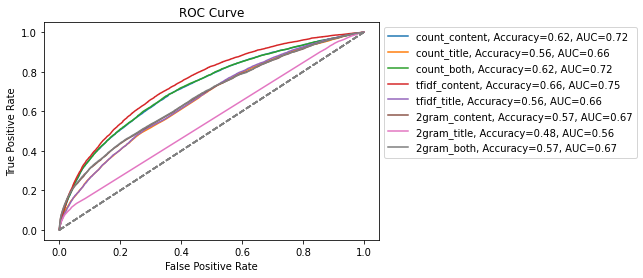

In [79]:
# fig, ax = plt.subplots(1, 3, figsize=(20, 10))

for model in models_metrics:
    plt_label = f"{model['model']}, Accuracy={round(model['accuracy'],2)}, AUC={round(model['avg_auc'], 2)}"
    plt.plot(model['all_fpr'], model['mean_tpr'], label=plt_label)

    plt.title(f'ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    lgd = plt.legend(bbox_to_anchor=(1, 1))
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.savefig('C:/ITC/final project/fake news/bias/Baseline/ROC_avg.jpg', bbox_inches='tight')


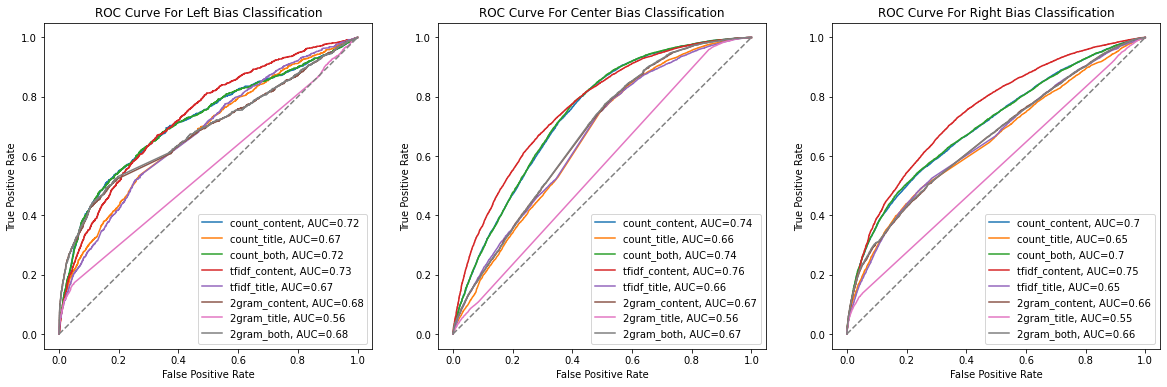

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, label in enumerate(CLASSES.keys()):
    for model in models_metrics:
        plt_label = f"{model['model']}, AUC={round(model['roc_auc'][label], 2)}"
        ax[i].plot(model['fpr'][label], model['tpr'][label], label=plt_label)
        
    ax[i].set_title(f'ROC Curve For {CLASSES[label]} Bias Classification')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].legend()
    ax[i].plot([0, 1], [0, 1], color="gray", linestyle="--")

fig.savefig('C:/ITC/final project/fake news/bias/Baseline/ROC_per_class.jpg', bbox_inches='tight')


## Feature importance:

In [161]:
from sklearn.linear_model import LogisticRegression
from matplotlib.ticker import FormatStrFormatter

In [68]:
best_model = [model for model in models_metrics if model['model'] == 'tfidf_content'][0]

In [70]:
best_clf = best_model['clf']

In [71]:
best_coef = best_clf.coef_

In [114]:
lr = LogisticRegression(multi_class='multinomial')
lr.fit(X_train_best, y_train_best)
lr_pred = lr.predict(X_test_best)
coeff = lr.coef_

In [130]:
lr.score(X_test_best, y_test_best)

0.7038946410778495

In [156]:
features = np.array(list(best_vectorizer.vocabulary_.keys()))
imp_coeff_cls = []
feat_imp_cls = []
classes = best_clf.classes_

for i in range(N_CLASSES):    
    features_imp = features[np.abs(coeff[i]).argsort()]
    abs_coeff = sorted(np.abs(coeff[i]))[0]
    features_imp_coeff = sorted(abs_coeff*np.std(X_train_best, 0))
    feat_imp_cls.append(features_imp)
    imp_coeff_cls.append(features_imp_coeff)

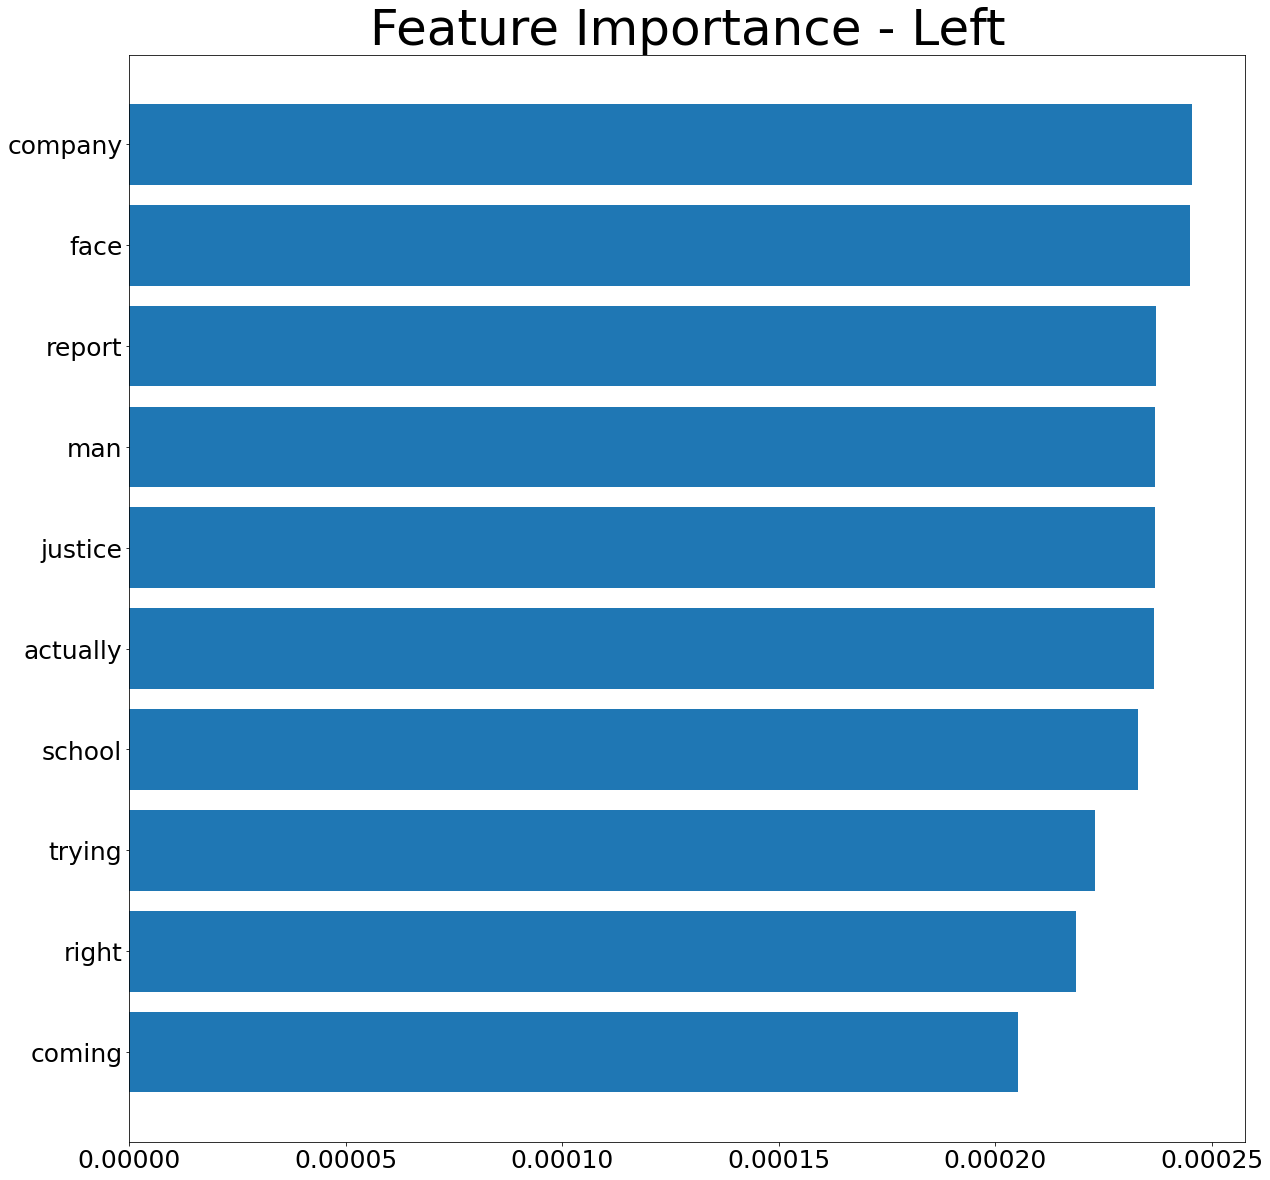

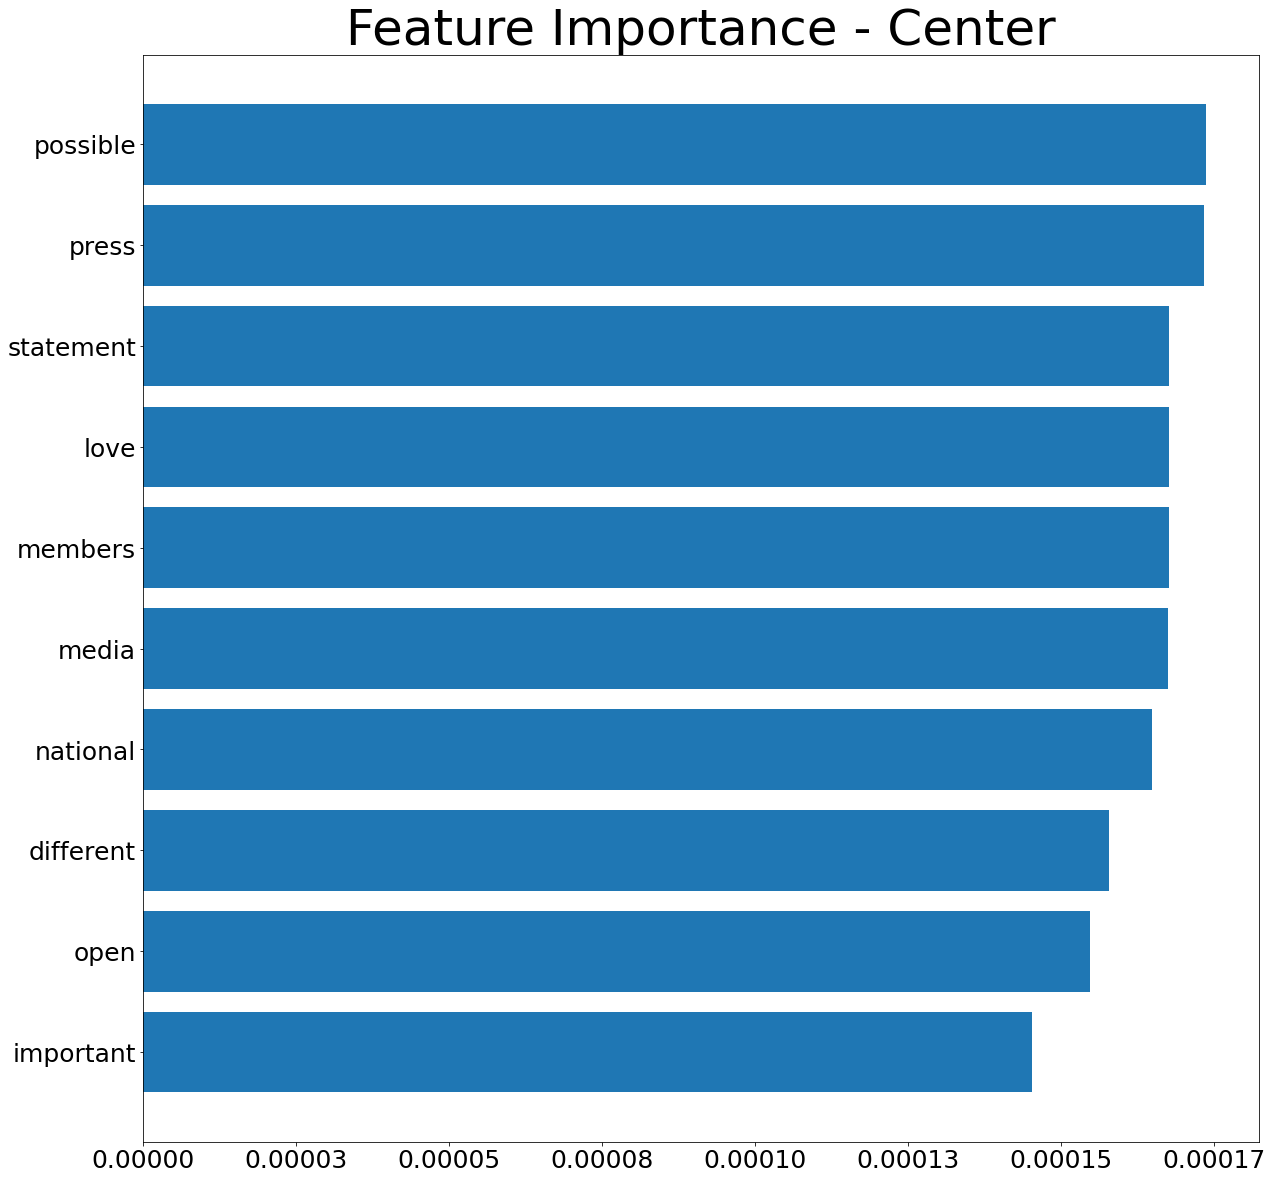

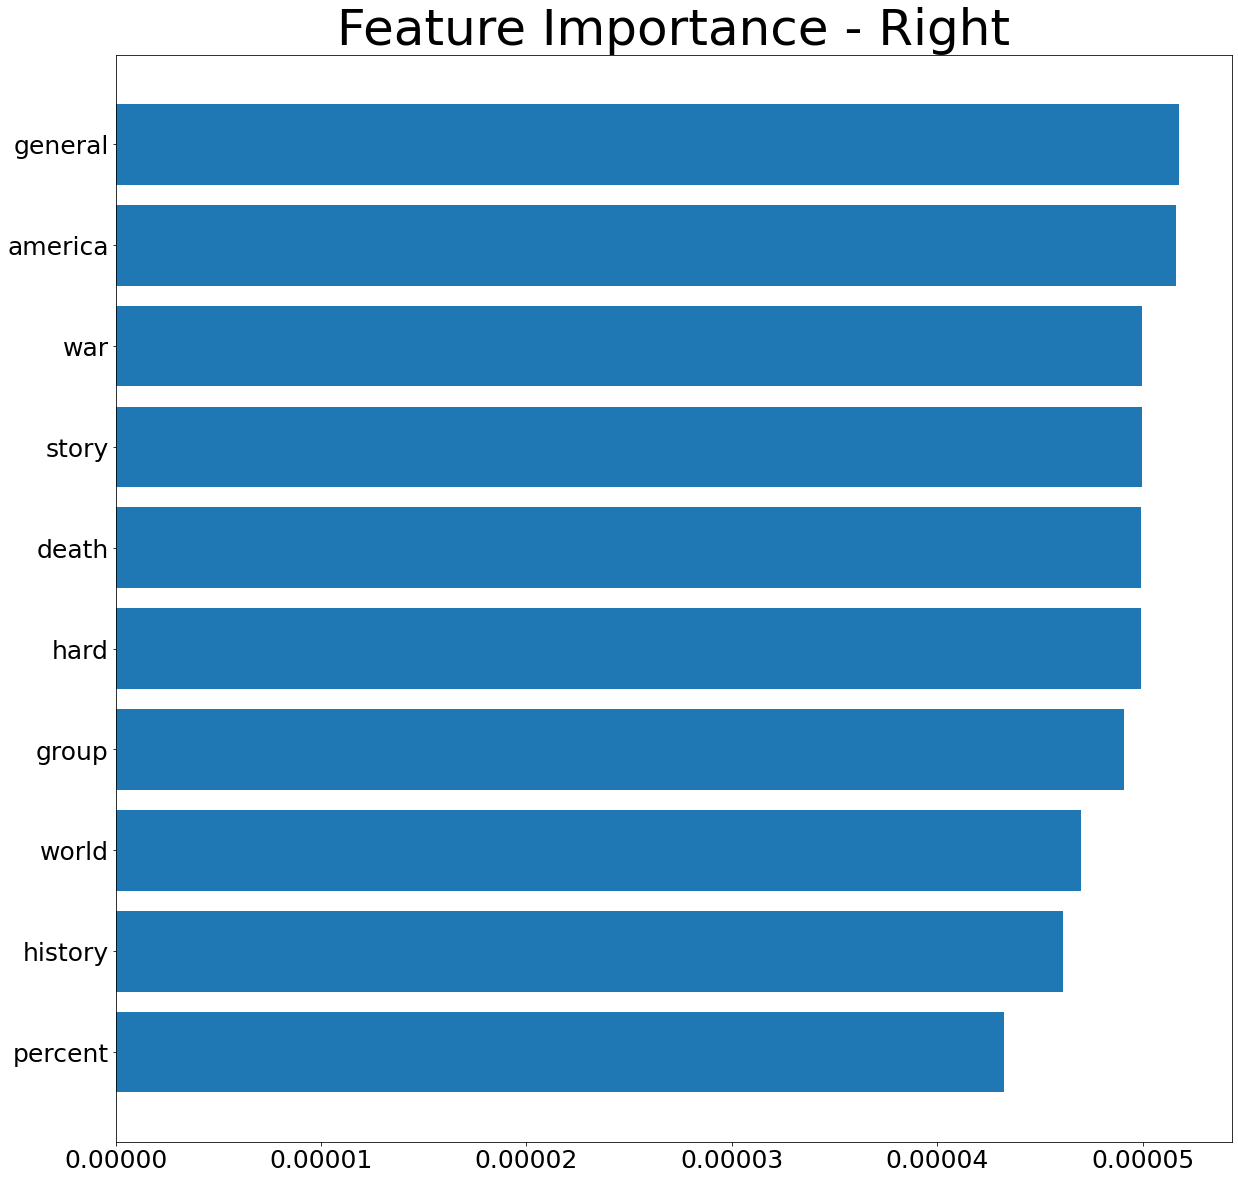

In [170]:
for i, label in enumerate(CLASSES.keys()):
    fig = plt.figure(figsize=(20, 20))
    plt.barh(feat_imp_cls[i][:10], imp_coeff_cls[i][:10])
    plt.title(f'Feature Importance - {CLASSES[classes[i]]}', fontsize=50)
    plt.tick_params(axis='x', labelsize=25)
    plt.tick_params(axis='y', labelsize=25)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.5f'))
    plt.savefig(f'C:/ITC/final project/fake news/bias/Baseline/feature_importance_top10_{CLASSES[classes[i]]}.jpg')
    plt.show();